In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.sample import sample_gen
from shapely.wkt import loads
from shapely.geometry import Point, MultiPolygon
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

print("Loading FIRED CONUS dataset...")
fired_conus_ak_df = pd.read_csv('../data/conus_ak/fired_conus_ak_2000_to_2024_events.csv')

df = fired_conus_ak_df.copy()

ignition_data = []

fire_ids = df['id'].unique()
print(f"Found {len(fire_ids)} unique fire events")


ELEV_DATA_DIR = '../data/LF2020_Elev_220_CONUS'
# FIRED_DATA_PATH = 'drive/MyDrive/ClimateML/data/data/conus_ak/fired_conus_ak_2000_to_2024_events.csv'

dem_path = "../data/LF2020_Elev_220_CONUS/Tif/LC20_Elev_220.tif"
slope_deg_path = '../data/LF2020_SlpD_220_CONUS/Tif/LC20_SlpD_220.tif'
slope_pct_path = '../data/LF2020_SlpP_220_CONUS/Tif/LC20_SlpP_220.tif'
slope_asp_path = '../data/LF2020_Asp_220_CONUS/Tif/LC20_Asp_220.tif'


if os.path.exists(dem_path):
    try:
        dem = rasterio.open(dem_path)
        print(f"DEM loaded from file: {dem_path}")
        dem_crs = dem.crs
        print(f"DEM CRS: {dem_crs}")
    except Exception as e:
        print(f"Error loading DEM: {e}")
        dem = None
else:
    print(f"DEM file not found at {dem_path}")
    dem = None

if os.path.exists(slope_deg_path):
    try:
        slope_deg = rasterio.open(slope_deg_path)
        print(f"Slope Degrees loaded from file: {slope_deg_path}")
        slope_deg_crs = slope_deg.crs
        print(f"Slope Degrees CRS: {slope_deg_crs}")
    except Exception as e:
        print(f"Error loading Slope Degrees: {e}")
        dem = None
else:
    print(f"Slope Degrees file not found at {slope_deg_path}")
    slope_deg = None

if os.path.exists(slope_pct_path):
    try:
        slope_pct = rasterio.open(slope_pct_path)
        print(f"Slope Pct loaded from file: {slope_pct_path}")
        slope_pct_crs = slope_pct.crs
        print(f"Slope Pct CRS: {slope_pct_crs}")
    except Exception as e:
        print(f"Error loading Slope Pct: {e}")
        slope_pct = None
else:
    print(f"Slope Pct file not found at {slope_pct_path}")
    dem = None

if os.path.exists(slope_asp_path):
    try:
        slope_asp = rasterio.open(slope_asp_path)
        print(f"Slope Asp loaded from file: {slope_asp_path}")
        slope_asp_crs = slope_asp.crs
        print(f"Slope Asp CRS: {slope_asp_crs}")
    except Exception as e:
        print(f"Error loading Slope Asp {e}")
        slope_asp = None
else:
    print(f"Slope Asp file not found at {slope_asp_path}")
    dem = None

Loading FIRED CONUS dataset...
Found 342731 unique fire events
DEM loaded from file: ../data/LF2020_Elev_220_CONUS/Tif/LC20_Elev_220.tif
DEM CRS: EPSG:5070
Slope Degrees loaded from file: ../data/LF2020_SlpD_220_CONUS/Tif/LC20_SlpD_220.tif
Slope Degrees CRS: EPSG:5070
Slope Pct loaded from file: ../data/LF2020_SlpP_220_CONUS/Tif/LC20_SlpP_220.tif
Slope Pct CRS: EPSG:5070
Slope Asp loaded from file: ../data/LF2020_Asp_220_CONUS/Tif/LC20_Asp_220.tif
Slope Asp CRS: EPSG:5070


In [7]:
def print_raster_info(raster, name):
    print(f"\n=== {name} Information ===")
    print("\nRaster Attributes:")
    print("-----------------")
    # Get all public attributes of the raster
    attributes = [attr for attr in dir(raster) if not attr.startswith('_')]
    
    # Group attributes by type for better organization
    metadata_attrs = []
    data_attrs = []
    method_attrs = []
    
    for attr in attributes:
        try:
            val = getattr(raster, attr)
            if callable(val):
                method_attrs.append(attr)
            elif isinstance(val, (str, int, float, bool, tuple, list, dict)):
                metadata_attrs.append(attr)
            else:
                data_attrs.append(attr)
        except:
            continue
    
    print("\nMetadata Attributes:")
    print("-------------------")
    for attr in sorted(metadata_attrs):
        try:
            val = getattr(raster, attr)
            val_type = type(val).__name__
            print(f"{attr:<20} (Type: {val_type})")
        except:
            continue
    
    print("\nData Structure Attributes:")
    print("-----------------------")
    for attr in sorted(data_attrs):
        try:
            val = getattr(raster, attr)
            val_type = type(val).__name__
            print(f"{attr:<20} (Type: {val_type})")
        except:
            continue
    
    print("\nKey Properties:")
    print("--------------")
    print(f"Driver:          {raster.driver}")
    print(f"File Mode:       {raster.mode}")
    print(f"Dimensions:      {raster.width} x {raster.height}")
    print(f"Number of Bands: {raster.count}")
    print(f"Data Type:       {raster.dtypes[0]}")
    print(f"NoData Value:    {raster.nodata}")
    
    print("\nGeoreferencing Information:")
    print("-------------------------")
    print(f"CRS:            {raster.crs}")
    print(f"Transform:      {raster.transform}")
    print(f"Resolution:     {raster.res}")
    print(f"Bounds:         {raster.bounds}")
    
    # Get band-specific information using indexes
    print("\nBand Information:")
    print("----------------")
    for i in range(1, raster.count + 1):
        print(f"\nBand {i}:")
        print(f"  Color Interpretation: {raster.colorinterp[i-1].name}")
        # Get band tags if they exist
        tags = raster.tags(i)
        if tags:
            print("  Band Tags:")
            for key, value in tags.items():
                print(f"    {key}: {value}")

# Print information for each raster
print("Analyzing raster datasets...")

if slope_deg is not None:
    print_raster_info(slope_deg, "Slope Degrees")
    
if slope_pct is not None:
    print_raster_info(slope_pct, "Slope Percent")
    
if slope_asp is not None:
    print_raster_info(slope_asp, "Slope Aspect")

# Check for data alignment
if all(x is not None for x in [slope_deg, slope_pct, slope_asp]):
    print("\n=== Data Alignment Analysis ===")
    print("\nCommon Properties Comparison:")
    print("--------------------------")
    properties = {
        'CRS': [r.crs for r in [slope_deg, slope_pct, slope_asp]],
        'Resolution': [r.res for r in [slope_deg, slope_pct, slope_asp]],
        'Bounds': [r.bounds for r in [slope_deg, slope_pct, slope_asp]],
        'Data Type': [r.dtypes[0] for r in [slope_deg, slope_pct, slope_asp]],
        'NoData Value': [r.nodata for r in [slope_deg, slope_pct, slope_asp]],
        'Dimensions': [(r.width, r.height) for r in [slope_deg, slope_pct, slope_asp]]
    }
    
    print("\nProperty Alignment Status:")
    for prop, values in properties.items():
        all_same = len(set(str(v) for v in values)) == 1
        print(f"{prop:<15} Aligned: {all_same}")
        if not all_same:
            print("  Values:")
            print("    Slope Degrees:", values[0])
            print("    Slope Percent:", values[1])
            print("    Slope Aspect:", values[2])

Analyzing raster datasets...

=== Slope Degrees Information ===

Raster Attributes:
-----------------

Metadata Attributes:
-------------------
block_shapes         (Type: list)
bounds               (Type: BoundingBox)
closed               (Type: bool)
colorinterp          (Type: tuple)
count                (Type: int)
descriptions         (Type: tuple)
driver               (Type: str)
dtypes               (Type: tuple)
files                (Type: list)
gcps                 (Type: tuple)
height               (Type: int)
indexes              (Type: tuple)
is_tiled             (Type: bool)
mask_flag_enums      (Type: tuple)
meta                 (Type: dict)
mode                 (Type: str)
name                 (Type: str)
nodata               (Type: float)
nodatavals           (Type: tuple)
offsets              (Type: tuple)
options              (Type: dict)
res                  (Type: tuple)
scales               (Type: tuple)
shape                (Type: tuple)
subdatasets          (Type

# Extract data

In [8]:
if dem is not None and slope_deg is not None and slope_pct is not None and slope_asp is not None:
    for fire_id in tqdm(fire_ids):
        fire_data = df[df['id'] == fire_id].sort_values('event_dur')
        if len(fire_data) == 0:
            continue

        ignition = fire_data.iloc[0]

        if 'geometry' in ignition and pd.notna(ignition['geometry']):
            geom = loads(ignition['geometry']) if isinstance(ignition['geometry'], str) else ignition['geometry']
        elif 'ig_utm_x' in ignition and 'ig_utm_y' in ignition:
            geom = Point(ignition['ig_utm_x'], ignition['ig_utm_y'])
        else:
            continue

        point_gdf = gpd.GeoDataFrame(geometry=[geom], crs="EPSG:3857")
        point_gdf = point_gdf.to_crs(dem.crs)
        ignition_geom = point_gdf.geometry.iloc[0]

        try:
            if isinstance(ignition_geom, Point):
                x, y = ignition_geom.x, ignition_geom.y
            elif isinstance(ignition_geom, (MultiPolygon)):
                centroid = ignition_geom.centroid
                x, y = centroid.x, centroid.y
            else:
                rep_point = ignition_geom.representative_point()
                x, y = rep_point.x, rep_point.y

            # Sample elevation
            elev_vals = list(sample_gen(dem, [(x, y)]))
            ignition_elev = float(elev_vals[0][0]) if elev_vals and elev_vals[0][0] is not None else None
            if ignition_elev is None:
                continue

            # Sample slope (deg)
            slope_deg_val = list(sample_gen(slope_deg, [(x, y)]))
            ignition_slope_deg = float(slope_deg_val[0][0]) if slope_deg_val and slope_deg_val[0][0] is not None else np.nan

            # Sample slope (%)
            slope_pct_val = list(sample_gen(slope_pct, [(x, y)]))
            ignition_slope_pct = float(slope_pct_val[0][0]) if slope_pct_val and slope_pct_val[0][0] is not None else np.nan

            # Sample slope aspect
            slope_asp_val = list(sample_gen(slope_asp, [(x, y)]))
            ignition_slope_asp = float(slope_asp_val[0][0]) if slope_asp_val and slope_asp_val[0][0] is not None else np.nan

            # Process and synchronize the values
            # Clip outliers and normalize values
            ignition_slope_deg = np.clip(ignition_slope_deg, 0, 60)
            ignition_slope_pct = np.clip(ignition_slope_pct, 0, 100)

            # Handle aspect special cases and normalization
            if ignition_slope_asp == -9999:  # NoData
                ignition_slope_asp = np.nan
                northness = np.nan
                eastness = np.nan
            elif ignition_slope_asp == -1 or ignition_slope_deg <= 2:  # Flat area
                ignition_slope_asp = -1
                northness = 0
                eastness = 0
            else:
                # Normalize aspect to 0-359 degrees
                ignition_slope_asp = ignition_slope_asp % 360
                # Calculate northness and eastness
                aspect_rad = np.radians(ignition_slope_asp)
                northness = np.cos(aspect_rad)  # -1 (south) to 1 (north)
                eastness = np.sin(aspect_rad)   # -1 (west) to 1 (east)

            # Elevation buffer
            centroid = ignition_geom.centroid
            buffer_size = 1000
            buffer_geom = centroid.buffer(buffer_size / 111000)
            buffer_gdf = gpd.GeoDataFrame(geometry=[buffer_geom], crs=dem.crs)
            minx, miny, maxx, maxy = buffer_gdf.total_bounds

            x_points = np.linspace(minx, maxx, 10)
            y_points = np.linspace(miny, maxy, 10)

            buffer_elevations = []
            buffer_aspects = []
            buffer_slopes_deg = []
            
            for x_grid in x_points:
                for y_grid in y_points:
                    point = Point(x_grid, y_grid)
                    if buffer_geom.contains(point):
                        # Sample all metrics for the buffer points
                        elev = list(sample_gen(dem, [(x_grid, y_grid)]))
                        asp = list(sample_gen(slope_asp, [(x_grid, y_grid)]))
                        slp = list(sample_gen(slope_deg, [(x_grid, y_grid)]))
                        
                        if elev and elev[0][0] is not None:
                            buffer_elevations.append(float(elev[0][0]))
                        if asp and asp[0][0] is not None and asp[0][0] != -9999:
                            if asp[0][0] != -1:  # Only include non-flat aspects
                                buffer_aspects.append(float(asp[0][0]) % 360)
                        if slp and slp[0][0] is not None:
                            buffer_slopes_deg.append(float(slp[0][0]))

            if buffer_elevations:  # Proceed if we have at least elevation data
                mean_elev = np.mean(buffer_elevations)
                min_elev = np.min(buffer_elevations)
                max_elev = np.max(buffer_elevations)
                std_elev = np.std(buffer_elevations)
                range_elev = max_elev - min_elev

                # Calculate terrain statistics
                if buffer_slopes_deg:
                    mean_slope = np.mean(buffer_slopes_deg)
                    std_slope = np.std(buffer_slopes_deg)
                else:
                    mean_slope = np.nan
                    std_slope = np.nan

                # Calculate circular statistics for aspect
                if buffer_aspects:
                    asp_rad = np.radians(buffer_aspects)
                    mean_northness = np.mean(np.cos(asp_rad))
                    mean_eastness = np.mean(np.sin(asp_rad))
                    mean_aspect = np.degrees(np.arctan2(mean_eastness, mean_northness)) % 360
                    aspect_consistency = np.sqrt(mean_northness**2 + mean_eastness**2)  # 0 (dispersed) to 1 (uniform)
                else:
                    mean_northness = np.nan
                    mean_eastness = np.nan
                    mean_aspect = np.nan
                    aspect_consistency = np.nan

                ignition_data.append({
                    'fire_id': fire_id,
                    'ig_date': ignition.get('ig_date'),
                    'fsr_km2_dy': ignition.get('fsr_km2_dy'),
                    'tot_ar_km2': ignition.get('tot_ar_km2'),
                    'event_dur': ignition.get('event_dur'),
                    'ignition_elev': ignition_elev,
                    'mean_elev': mean_elev,
                    'min_elev': min_elev,
                    'max_elev': max_elev,
                    'std_elev': std_elev,
                    'range_elev': range_elev,
                    'land_cover': ignition.get('lc_name'),
                    'ecoregion': ignition.get('eco_name'),
                    'ignition_slope_deg': ignition_slope_deg,
                    'ignition_slope_pct': ignition_slope_pct,
                    'ignition_slope_asp': ignition_slope_asp,
                    'ignition_northness': northness,
                    'ignition_eastness': eastness,
                    'mean_slope': mean_slope,
                    'std_slope': std_slope,
                    'mean_aspect': mean_aspect,
                    'aspect_consistency': aspect_consistency,
                    'mean_northness': mean_northness,
                    'mean_eastness': mean_eastness
                })

        except Exception as e:
            print(f"Error processing fire ID {fire_id}: {e}")
            continue
else:
    print("Cannot proceed without valid DEM and slope data.")

100%|██████████| 342731/342731 [56:01<00:00, 101.96it/s]


In [1]:
import os
import pandas as pd

ignition_data_path = '../data/ignition_slope_data_unprocessed.csv'
if os.path.exists(ignition_data_path):
    ignition_df = pd.read_csv(ignition_data_path, index_col=0)
else:
    ignition_df = pd.DataFrame(ignition_data)
    ignition_df.to_csv(ignition_data_path)

In [2]:
ignition_df.head()

,fire_id,ig_date,fsr_km2_dy,tot_ar_km2,event_dur,ignition_elev,mean_elev,min_elev,max_elev,std_elev,...,ignition_slope_pct,ignition_slope_asp,ignition_northness,ignition_eastness,mean_slope,std_slope,mean_aspect,aspect_consistency,mean_northness,mean_eastness
0,1,2007-02-01 00:00:00,0.214659,0.214659,1,189.0,189.0,189.0,189.0,0.0,...,2.0,-1.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN
1,3,2003-10-31 00:00:00,0.214659,1.073293,5,200.0,200.0,200.0,200.0,0.0,...,1.0,-1.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN
2,4,2007-02-02 00:00:00,0.429317,0.429317,1,211.0,211.0,211.0,211.0,0.0,...,1.0,-1.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN
3,5,2013-10-30 00:00:00,0.214659,0.214659,1,211.0,211.0,211.0,211.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
4,6,2013-10-30 00:00:00,0.214659,0.214659,1,214.0,214.0,214.0,214.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [3]:
ignition_df['ignition_slope_asp'].value_counts()

ignition_slope_asp
 7.0      118528
-1.0       67101
 286.0       136
 119.0       122
 116.0       122
           ...  
 38.0         69
 39.0         68
 17.0         66
 350.0        66
 16.0         65
Name: count, Length: 361, dtype: int64

In [4]:
ignition_df['ignition_northness'].value_counts()

ignition_northness
 0.992546    118633
 0.000000     67101
-0.173648       229
 0.573576       228
 0.292372       222
              ...  
-0.034899        73
-0.342020        72
 0.788011        69
 0.777146        68
 0.956305        66
Name: count, Length: 297, dtype: int64

In [5]:
ignition_df['land_cover'].value_counts()

land_cover
Croplands                              124077
Grasslands                              61561
Woody Savannas                          60420
Savannas                                36529
Evergreen Needleleaf Forests            16176
Cropland/Natural Vegetation Mosaics     10036
Deciduous Broadleaf Forests              9642
Open Shrublands                          6117
Evergreen Broadleaf Forests              4865
Barren                                   4520
Mixed Forests                            4123
Permanent Wetlands                       1785
Water Bodies                             1755
Closed Shrublands                         608
Urban and Built-up Lands                  322
Permanent Snow and Ice                    162
Deciduous Needleleaf Forests               33
Name: count, dtype: int64

In [6]:
ignition_df.columns

Index(['fire_id', 'ig_date', 'fsr_km2_dy', 'tot_ar_km2', 'event_dur',
       'ignition_elev', 'mean_elev', 'min_elev', 'max_elev', 'std_elev',
       'range_elev', 'land_cover', 'ecoregion', 'ignition_slope_deg',
       'ignition_slope_pct', 'ignition_slope_asp', 'ignition_northness',
       'ignition_eastness', 'mean_slope', 'std_slope', 'mean_aspect',
       'aspect_consistency', 'mean_northness', 'mean_eastness'],
      dtype='object')


--- Predicting fsr_km2_dy individually ---
RandomForest: MSE=4.4658, R2=-0.1025
XGBoost: MSE=4.0742, R2=-0.0059
LinearRegression: MSE=3.9898, R2=0.0150

--- Predicting tot_ar_km2 individually ---
RandomForest: MSE=1436.4520, R2=-0.0654
XGBoost: MSE=1381.5714, R2=-0.0247
LinearRegression: MSE=1343.2536, R2=0.0037

--- Predicting event_dur individually ---
RandomForest: MSE=15.7490, R2=-0.0495
XGBoost: MSE=14.8731, R2=0.0089
LinearRegression: MSE=14.8708, R2=0.0090

--- Multi-output prediction ---
RandomForest_Multi: MSE=485.5556, R2=-0.0725
XGBoost_Multi: MSE=466.8396, R2=-0.0072
LinearRegression_Multi: MSE=454.0380, R2=0.0092


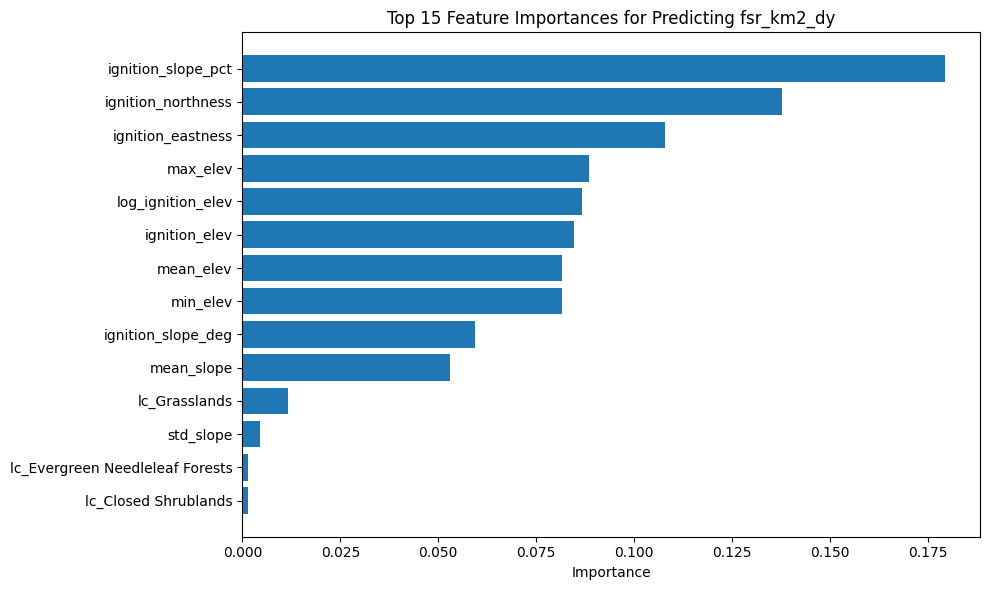

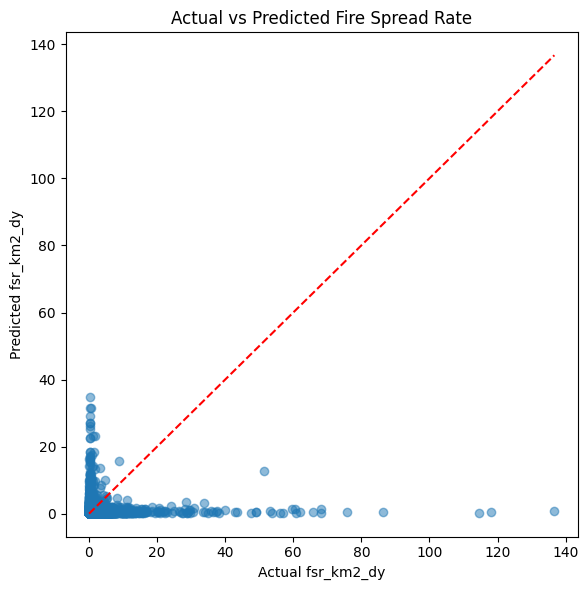

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Drop columns with heavy NaNs IF they exist
cols_to_drop = ['mean_aspect', 'aspect_consistency', 'mean_northness', 'mean_eastness']
ignition_df = ignition_df.drop(columns=[col for col in cols_to_drop if col in ignition_df.columns])

# Drop rows where any critical target feature is missing
ignition_df = ignition_df.dropna(subset=['fsr_km2_dy', 'tot_ar_km2', 'event_dur'])

# Feature Engineering
features = ['ignition_elev', 'mean_elev', 'min_elev', 'max_elev', 'std_elev', 'range_elev',
            'ignition_slope_deg', 'ignition_slope_pct', 'ignition_northness', 'ignition_eastness',
            'mean_slope', 'std_slope']

# Add land_cover dummies if manageable
if ignition_df['land_cover'].nunique() < 20:
    lc_dummies = pd.get_dummies(ignition_df['land_cover'], prefix='lc')
    ignition_df = pd.concat([ignition_df, lc_dummies], axis=1)
    features.extend(lc_dummies.columns.tolist())

# Add ecoregion dummies if manageable
if ignition_df['ecoregion'].nunique() < 20:
    eco_dummies = pd.get_dummies(ignition_df['ecoregion'], prefix='eco')
    ignition_df = pd.concat([ignition_df, eco_dummies], axis=1)
    features.extend(eco_dummies.columns.tolist())

# Additional feature engineering
ignition_df['log_ignition_elev'] = np.log1p(ignition_df['ignition_elev'])
ignition_df['elev_range_ratio'] = ignition_df['range_elev'] / (ignition_df['mean_elev'] + 1)
features.extend(['log_ignition_elev', 'elev_range_ratio'])

# --- FIX: remove infs and nans generated during feature engineering ---
ignition_df = ignition_df.replace([np.inf, -np.inf], np.nan).dropna()

# Inputs and Outputs
X = ignition_df[features]
y = ignition_df[['fsr_km2_dy', 'tot_ar_km2', 'event_dur']]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Models
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    'LinearRegression': LinearRegression()
}

# Predict each target individually
for target in y.columns:
    print(f"\n--- Predicting {target} individually ---")
    for name, model in models.items():
        model.fit(X_train, y_train[target])
        preds = model.predict(X_test)
        mse = mean_squared_error(y_test[target], preds)
        r2 = r2_score(y_test[target], preds)
        print(f"{name}: MSE={mse:.4f}, R2={r2:.4f}")

# Predict all three targets together (multi-output)
print("\n--- Multi-output prediction ---")

multi_models = {
    'RandomForest_Multi': MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
    'XGBoost_Multi': MultiOutputRegressor(XGBRegressor(n_estimators=100, random_state=42, verbosity=0)),
    'LinearRegression_Multi': MultiOutputRegressor(LinearRegression())
}

for name, model in multi_models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds, multioutput='uniform_average')
    print(f"{name}: MSE={mse:.4f}, R2={r2:.4f}")

# Feature Importance (for Random Forest on fsr_km2_dy)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train['fsr_km2_dy'])
importances = rf.feature_importances_
feature_names = X.columns

feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp = feat_imp.sort_values(by='importance', ascending=False)

# Plot Feature Importances
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['feature'][:15][::-1], feat_imp['importance'][:15][::-1])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances for Predicting fsr_km2_dy')
plt.tight_layout()
plt.show()

# Plot Prediction vs Actual for fsr_km2_dy
best_rf = RandomForestRegressor(n_estimators=100, random_state=42)
best_rf.fit(X_train, y_train['fsr_km2_dy'])
preds_rf = best_rf.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test['fsr_km2_dy'], preds_rf, alpha=0.5)
plt.plot([y_test['fsr_km2_dy'].min(), y_test['fsr_km2_dy'].max()],
         [y_test['fsr_km2_dy'].min(), y_test['fsr_km2_dy'].max()], 'r--')
plt.xlabel('Actual fsr_km2_dy')
plt.ylabel('Predicted fsr_km2_dy')
plt.title('Actual vs Predicted Fire Spread Rate')
plt.tight_layout()
plt.show()

# Performance Without One-Encoded Vegetation Variables

/opt/homebrew/anaconda3/envs/311_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/anaconda3/envs/311_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)



--- Predicting fsr_km2_dy individually ---
RandomForest: MSE=4.2850, R2=-0.0579
XGBoost: MSE=4.2227, R2=-0.0425
LinearRegression: MSE=4.0265, R2=0.0059

--- Predicting tot_ar_km2 individually ---
RandomForest: MSE=1388.7528, R2=-0.0300
XGBoost: MSE=1403.8053, R2=-0.0412
LinearRegression: MSE=1346.1876, R2=0.0015

--- Predicting event_dur individually ---
RandomForest: MSE=15.5589, R2=-0.0368
XGBoost: MSE=15.1595, R2=-0.0102
LinearRegression: MSE=14.9930, R2=0.0009

--- Multi-output prediction ---
RandomForest_Multi: MSE=469.5322, R2=-0.0416
XGBoost_Multi: MSE=474.3958, R2=-0.0313
LinearRegression_Multi: MSE=455.0690, R2=0.0028


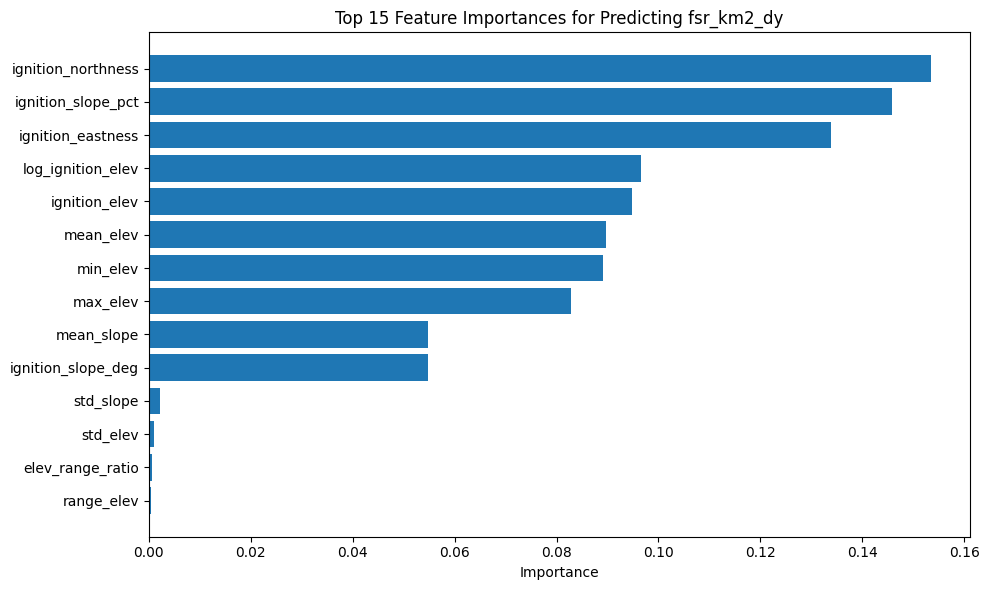

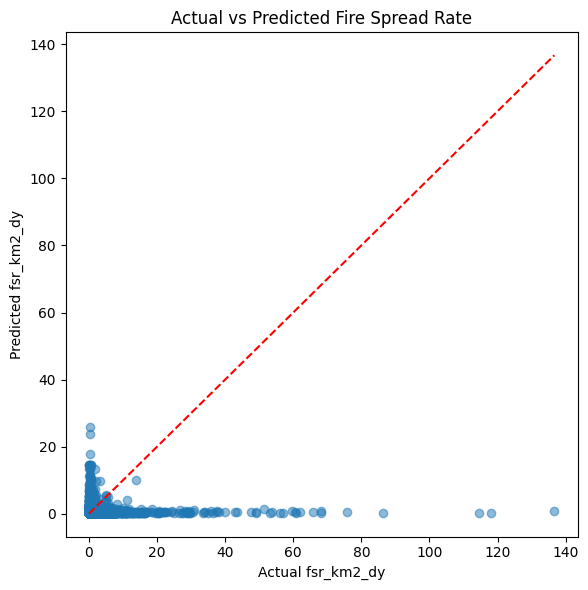

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Drop columns with heavy NaNs IF they exist
cols_to_drop = ['mean_aspect', 'aspect_consistency', 'mean_northness', 'mean_eastness']
ignition_df = ignition_df.drop(columns=[col for col in cols_to_drop if col in ignition_df.columns])

# Drop rows where any critical target feature is missing
ignition_df = ignition_df.dropna(subset=['fsr_km2_dy', 'tot_ar_km2', 'event_dur'])

# Feature Engineering
features = ['ignition_elev', 'mean_elev', 'min_elev', 'max_elev', 'std_elev', 'range_elev',
            'ignition_slope_deg', 'ignition_slope_pct', 'ignition_northness', 'ignition_eastness',
            'mean_slope', 'std_slope']

# Additional feature engineering
ignition_df['log_ignition_elev'] = np.log1p(ignition_df['ignition_elev'])
ignition_df['elev_range_ratio'] = ignition_df['range_elev'] / (ignition_df['mean_elev'] + 1)
features.extend(['log_ignition_elev', 'elev_range_ratio'])

# --- FIX: remove infs and nans generated during feature engineering ---
ignition_df = ignition_df.replace([np.inf, -np.inf], np.nan).dropna()

# Inputs and Outputs
X = ignition_df[features]
y = ignition_df[['fsr_km2_dy', 'tot_ar_km2', 'event_dur']]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Models
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    'LinearRegression': LinearRegression()
}

# Predict each target individually
for target in y.columns:
    print(f"\n--- Predicting {target} individually ---")
    for name, model in models.items():
        model.fit(X_train, y_train[target])
        preds = model.predict(X_test)
        mse = mean_squared_error(y_test[target], preds)
        r2 = r2_score(y_test[target], preds)
        print(f"{name}: MSE={mse:.4f}, R2={r2:.4f}")

# Predict all three targets together (multi-output)
print("\n--- Multi-output prediction ---")

multi_models = {
    'RandomForest_Multi': MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
    'XGBoost_Multi': MultiOutputRegressor(XGBRegressor(n_estimators=100, random_state=42, verbosity=0)),
    'LinearRegression_Multi': MultiOutputRegressor(LinearRegression())
}

for name, model in multi_models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds, multioutput='uniform_average')
    print(f"{name}: MSE={mse:.4f}, R2={r2:.4f}")

# Feature Importance (for Random Forest on fsr_km2_dy)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train['fsr_km2_dy'])
importances = rf.feature_importances_
feature_names = X.columns

feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp = feat_imp.sort_values(by='importance', ascending=False)

# Plot Feature Importances
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['feature'][:15][::-1], feat_imp['importance'][:15][::-1])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances for Predicting fsr_km2_dy')
plt.tight_layout()
plt.show()

# Plot Prediction vs Actual for fsr_km2_dy
best_rf = RandomForestRegressor(n_estimators=100, random_state=42)
best_rf.fit(X_train, y_train['fsr_km2_dy'])
preds_rf = best_rf.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test['fsr_km2_dy'], preds_rf, alpha=0.5)
plt.plot([y_test['fsr_km2_dy'].min(), y_test['fsr_km2_dy'].max()],
         [y_test['fsr_km2_dy'].min(), y_test['fsr_km2_dy'].max()], 'r--')
plt.xlabel('Actual fsr_km2_dy')
plt.ylabel('Predicted fsr_km2_dy')
plt.title('Actual vs Predicted Fire Spread Rate')
plt.tight_layout()
plt.show()


--- Predicting fsr_km2_dy individually ---
RandomForest: MSE=4.2601, R2=-0.0517
XGBoost: MSE=4.1170, R2=-0.0164
LinearRegression: MSE=4.0258, R2=0.0061

--- Predicting tot_ar_km2 individually ---
RandomForest: MSE=1387.0806, R2=-0.0288
XGBoost: MSE=1386.0554, R2=-0.0280
LinearRegression: MSE=1346.1366, R2=0.0016

--- Predicting event_dur individually ---
RandomForest: MSE=15.6036, R2=-0.0398
XGBoost: MSE=15.1381, R2=-0.0088
LinearRegression: MSE=14.9921, R2=0.0009

--- Multi-output prediction ---
RandomForest_Multi: MSE=468.9814, R2=-0.0401
XGBoost_Multi: MSE=468.4369, R2=-0.0177
LinearRegression_Multi: MSE=455.0515, R2=0.0029


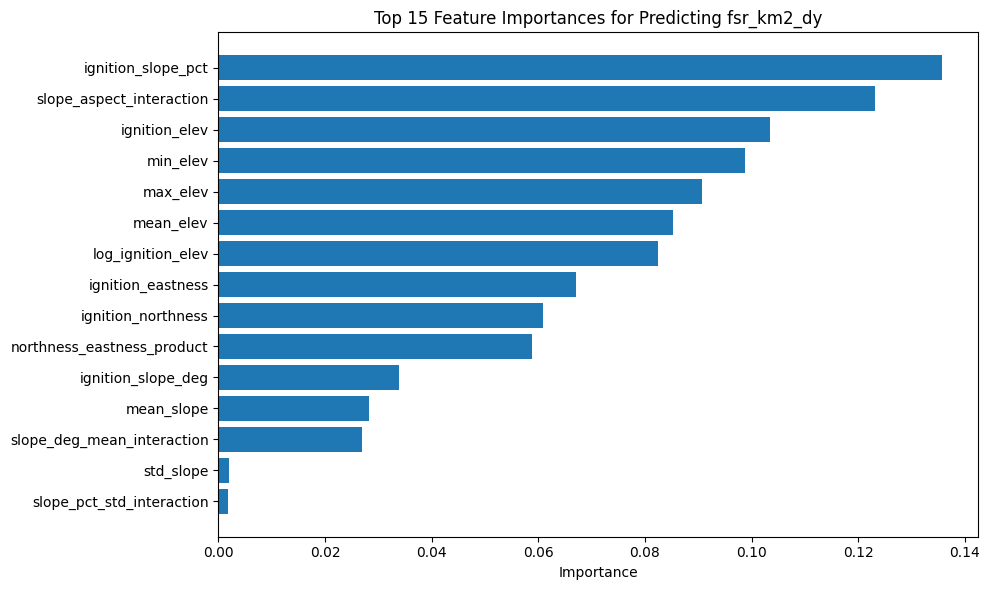

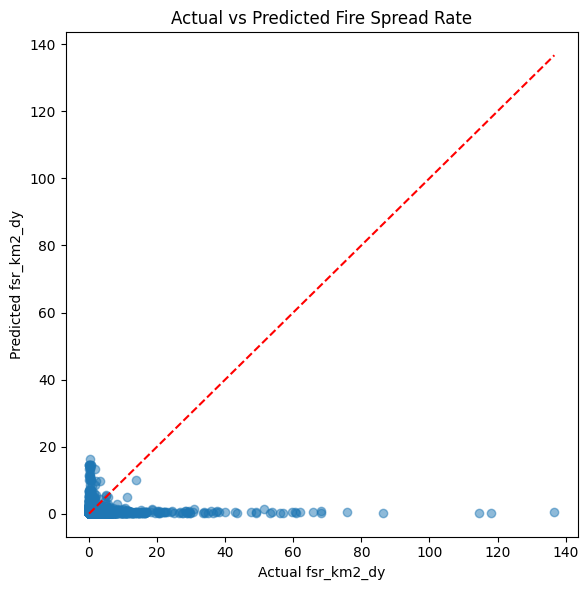

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Drop columns with heavy NaNs IF they exist
cols_to_drop = ['mean_aspect', 'aspect_consistency', 'mean_northness', 'mean_eastness']
ignition_df = ignition_df.drop(columns=[col for col in cols_to_drop if col in ignition_df.columns])

# Drop rows where any critical target feature is missing
ignition_df = ignition_df.dropna(subset=['fsr_km2_dy', 'tot_ar_km2', 'event_dur'])

# Base Feature Engineering
features = ['ignition_elev', 'mean_elev', 'min_elev', 'max_elev', 'std_elev', 'range_elev',
            'ignition_slope_deg', 'ignition_slope_pct', 'ignition_northness', 'ignition_eastness',
            'mean_slope', 'std_slope']

# Additional feature engineering
ignition_df['log_ignition_elev'] = np.log1p(ignition_df['ignition_elev'])
ignition_df['elev_range_ratio'] = ignition_df['range_elev'] / (ignition_df['mean_elev'] + 1)

# ---- New interaction features ----
ignition_df['slope_aspect_interaction'] = ignition_df['ignition_slope_deg'] * (ignition_df['ignition_northness'] + ignition_df['ignition_eastness'])
ignition_df['slope_pct_std_interaction'] = ignition_df['ignition_slope_pct'] * ignition_df['std_slope']
ignition_df['slope_deg_mean_interaction'] = ignition_df['ignition_slope_deg'] * ignition_df['mean_slope']
ignition_df['northness_eastness_product'] = ignition_df['ignition_northness'] * ignition_df['ignition_eastness']

# Add new features to feature list
features.extend([
    'log_ignition_elev', 'elev_range_ratio',
    'slope_aspect_interaction',
    'slope_pct_std_interaction',
    'slope_deg_mean_interaction',
    'northness_eastness_product'
])

# --- Clean up after feature engineering ---
ignition_df = ignition_df.replace([np.inf, -np.inf], np.nan).dropna()

# Inputs and Outputs
X = ignition_df[features]
y = ignition_df[['fsr_km2_dy', 'tot_ar_km2', 'event_dur']]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Models
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    'LinearRegression': LinearRegression()
}

# Predict each target individually
for target in y.columns:
    print(f"\n--- Predicting {target} individually ---")
    for name, model in models.items():
        model.fit(X_train, y_train[target])
        preds = model.predict(X_test)
        mse = mean_squared_error(y_test[target], preds)
        r2 = r2_score(y_test[target], preds)
        print(f"{name}: MSE={mse:.4f}, R2={r2:.4f}")

# Predict all three targets together (multi-output)
print("\n--- Multi-output prediction ---")

multi_models = {
    'RandomForest_Multi': MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
    'XGBoost_Multi': MultiOutputRegressor(XGBRegressor(n_estimators=100, random_state=42, verbosity=0)),
    'LinearRegression_Multi': MultiOutputRegressor(LinearRegression())
}

for name, model in multi_models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds, multioutput='uniform_average')
    print(f"{name}: MSE={mse:.4f}, R2={r2:.4f}")

# Feature Importance (for Random Forest on fsr_km2_dy)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train['fsr_km2_dy'])
importances = rf.feature_importances_
feature_names = X.columns

feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp = feat_imp.sort_values(by='importance', ascending=False)

# Plot Feature Importances
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['feature'][:15][::-1], feat_imp['importance'][:15][::-1])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances for Predicting fsr_km2_dy')
plt.tight_layout()
plt.show()

# Plot Prediction vs Actual for fsr_km2_dy
best_rf = RandomForestRegressor(n_estimators=100, random_state=42)
best_rf.fit(X_train, y_train['fsr_km2_dy'])
preds_rf = best_rf.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test['fsr_km2_dy'], preds_rf, alpha=0.5)
plt.plot([y_test['fsr_km2_dy'].min(), y_test['fsr_km2_dy'].max()],
         [y_test['fsr_km2_dy'].min(), y_test['fsr_km2_dy'].max()], 'r--')
plt.xlabel('Actual fsr_km2_dy')
plt.ylabel('Predicted fsr_km2_dy')
plt.title('Actual vs Predicted Fire Spread Rate')
plt.tight_layout()
plt.show()


In [4]:
# Drop columns with heavy NaNs
cols_to_drop = ['mean_aspect', 'aspect_consistency', 'mean_northness', 'mean_eastness']
ignition_df = ignition_df.drop(columns=[col for col in cols_to_drop if col in ignition_df.columns])

# Drop rows where critical target missing
ignition_df = ignition_df.dropna(subset=['fsr_km2_dy', 'tot_ar_km2', 'event_dur'])

# Base terrain features
features = ['ignition_elev', 'mean_elev', 'std_elev', 
            'ignition_slope_deg', 'ignition_slope_pct', 
            'ignition_northness', 'ignition_eastness',
            'mean_slope', 'std_slope']

# --- Smarter Engineering ---

# Log transforms
ignition_df['log_ignition_elev'] = np.log1p(ignition_df['ignition_elev'])
ignition_df['log_mean_elev'] = np.log1p(ignition_df['mean_elev'])

# Ratios
ignition_df['slope_ratio'] = ignition_df['ignition_slope_deg'] / (ignition_df['mean_slope'] + 1)

# Composite slope-exposure term
ignition_df['northness_weighted_slope'] = ignition_df['ignition_northness'] * ignition_df['ignition_slope_pct']
ignition_df['eastness_weighted_slope'] = ignition_df['ignition_eastness'] * ignition_df['ignition_slope_pct']

# Elevation normalized ruggedness
ignition_df['ruggedness'] = ignition_df['std_slope'] / (ignition_df['mean_slope'] + 0.1)

# Feature list
features.extend([
    'log_ignition_elev', 'log_mean_elev', 
    'slope_ratio', 
    'northness_weighted_slope', 'eastness_weighted_slope', 
    'ruggedness'
])

# Clean
ignition_df = ignition_df.replace([np.inf, -np.inf], np.nan).dropna()

# Inputs and Outputs
X = ignition_df[features]
y = ignition_df[['fsr_km2_dy', 'tot_ar_km2', 'event_dur']]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Models
models = {
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    'LinearRegression': LinearRegression()
}

# Predict each target individually
for target in y.columns:
    print(f"\n--- Predicting {target} individually ---")
    for name, model in models.items():
        model.fit(X_train, y_train[target])
        preds = model.predict(X_test)
        mse = mean_squared_error(y_test[target], preds)
        r2 = r2_score(y_test[target], preds)
        print(f"{name}: MSE={mse:.4f}, R2={r2:.4f}")

# Multi-output prediction
print("\n--- Multi-output prediction ---")

multi_models = {
    'RandomForest_Multi': MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42)),
    'XGBoost_Multi': MultiOutputRegressor(XGBRegressor(n_estimators=100, random_state=42, verbosity=0)),
    'LinearRegression_Multi': MultiOutputRegressor(LinearRegression())
}

for name, model in multi_models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds, multioutput='uniform_average')
    print(f"{name}: MSE={mse:.4f}, R2={r2:.4f}")



--- Predicting fsr_km2_dy individually ---
RandomForest: MSE=4.2436, R2=-0.0477
XGBoost: MSE=4.2059, R2=-0.0384
LinearRegression: MSE=4.0257, R2=0.0061

--- Predicting tot_ar_km2 individually ---
RandomForest: MSE=1384.4357, R2=-0.0268
XGBoost: MSE=1378.0019, R2=-0.0220
LinearRegression: MSE=1346.0460, R2=0.0017

--- Predicting event_dur individually ---
RandomForest: MSE=15.5724, R2=-0.0377
XGBoost: MSE=15.1269, R2=-0.0080
LinearRegression: MSE=14.9934, R2=0.0009

--- Multi-output prediction ---
RandomForest_Multi: MSE=468.0839, R2=-0.0374
XGBoost_Multi: MSE=465.7783, R2=-0.0228
LinearRegression_Multi: MSE=455.0217, R2=0.0029


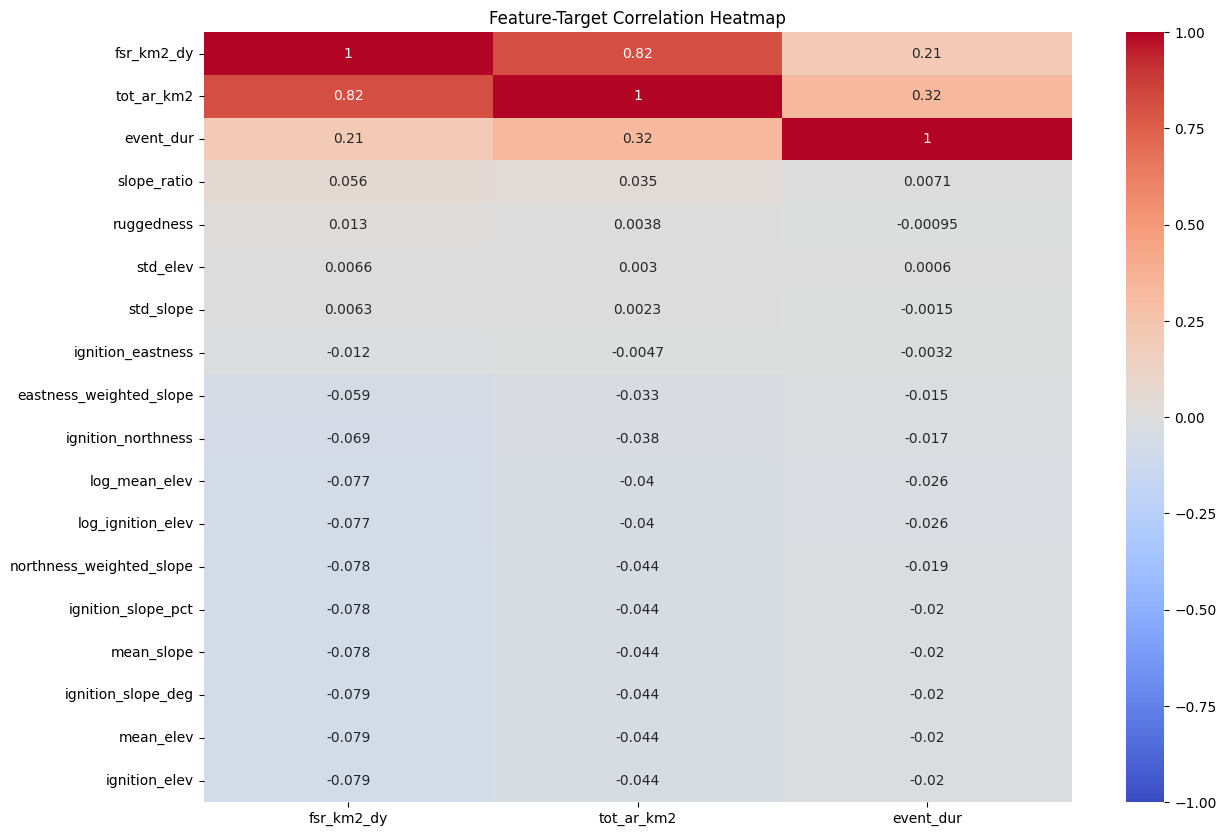

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine features + targets
eda_df = ignition_df[features + ['fsr_km2_dy', 'tot_ar_km2', 'event_dur']]

# Compute correlation matrix
corr = eda_df.corr()

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr[['fsr_km2_dy', 'tot_ar_km2', 'event_dur']].sort_values(by='fsr_km2_dy', ascending=False), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature-Target Correlation Heatmap')
plt.show()


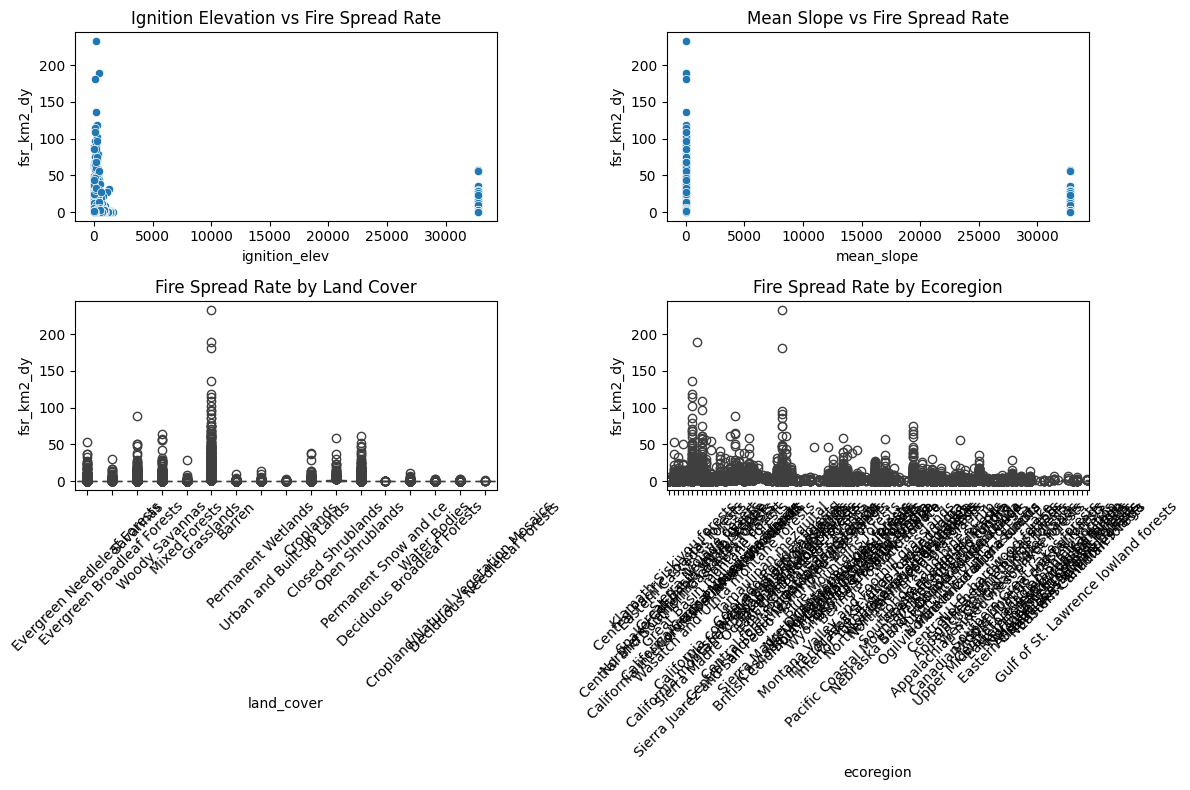

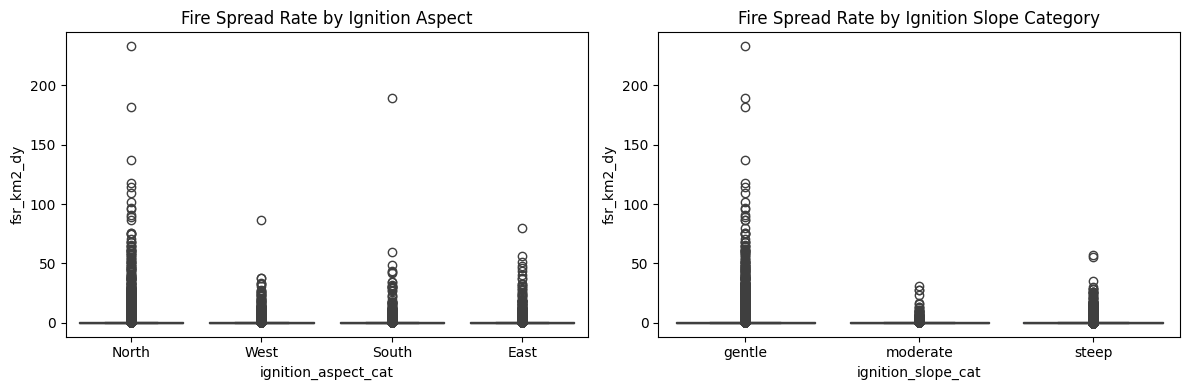

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032892 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1366
[LightGBM] [Info] Number of data points in the train set: 86460, number of used features: 82
[LightGBM] [Info] Start training from score 0.458320
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1371
[LightGBM] [Info] Number of data points in the train set: 86460, number of used features: 82
[LightGBM] [Info] Start training from score 0.460859
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

KeyboardInterrupt: 

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import shap
import warnings
warnings.filterwarnings('ignore')

# --- Load and Clean ---
cols_to_drop = ['mean_aspect', 'aspect_consistency', 'mean_northness', 'mean_eastness']
ignition_df = ignition_df.drop(columns=[col for col in cols_to_drop if col in ignition_df.columns], errors='ignore')
ignition_df = ignition_df.dropna(subset=['fsr_km2_dy', 'tot_ar_km2', 'event_dur'])

# --- Initial Visualizations ---
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.scatterplot(x='ignition_elev', y='fsr_km2_dy', data=ignition_df)
plt.title('Ignition Elevation vs Fire Spread Rate')
plt.subplot(2, 2, 2)
sns.scatterplot(x='mean_slope', y='fsr_km2_dy', data=ignition_df)
plt.title('Mean Slope vs Fire Spread Rate')
plt.subplot(2, 2, 3)
sns.boxplot(x='land_cover', y='fsr_km2_dy', data=ignition_df)
plt.xticks(rotation=45)
plt.title('Fire Spread Rate by Land Cover')
plt.subplot(2, 2, 4)
sns.boxplot(x='ecoregion', y='fsr_km2_dy', data=ignition_df)
plt.xticks(rotation=45)
plt.title('Fire Spread Rate by Ecoregion')
plt.tight_layout()
plt.show()

# --- Feature Engineering ---
features = ['ignition_elev', 'mean_elev', 'min_elev', 'max_elev', 'std_elev', 'range_elev',
            'ignition_slope_deg', 'ignition_slope_pct', 'ignition_northness', 'ignition_eastness',
            'mean_slope', 'std_slope']

# Categorical dummies
if ignition_df['land_cover'].nunique() < 20:
    lc_dummies = pd.get_dummies(ignition_df['land_cover'], prefix='lc')
    ignition_df = pd.concat([ignition_df, lc_dummies], axis=1)
    features.extend(lc_dummies.columns.tolist())

if ignition_df['ecoregion'].nunique() < 20:
    eco_dummies = pd.get_dummies(ignition_df['ecoregion'], prefix='eco')
    ignition_df = pd.concat([ignition_df, eco_dummies], axis=1)
    features.extend(eco_dummies.columns.tolist())

# Existing engineered features
ignition_df['log_ignition_elev'] = np.log1p(ignition_df['ignition_elev'])
ignition_df['elev_range_ratio'] = ignition_df['range_elev'] / (ignition_df['mean_elev'] + 1)
features += ['log_ignition_elev', 'elev_range_ratio']

# New features
# Relative elevation
ignition_df['relative_elev'] = (ignition_df['ignition_elev'] - ignition_df['min_elev']) / (ignition_df['max_elev'] - ignition_df['min_elev'] + 1e-6)
features.append('relative_elev')

# Elevation difference
ignition_df['elev_difference'] = ignition_df['ignition_elev'] - ignition_df['mean_elev']
features.append('elev_difference')

# Slope difference
ignition_df['slope_difference'] = ignition_df['ignition_slope_deg'] - ignition_df['mean_slope']
features.append('slope_difference')

# Aspect categories
ignition_df['ignition_aspect_deg'] = np.degrees(np.arctan2(ignition_df['ignition_eastness'], ignition_df['ignition_northness']))
ignition_df['ignition_aspect_deg'] = (ignition_df['ignition_aspect_deg'] % 360 + 360) % 360

# Aspect categories
def categorize_aspect(aspect_deg):
    if (aspect_deg >= 0 and aspect_deg < 45) or (aspect_deg >= 315 and aspect_deg <= 360):
        return 'North'
    elif aspect_deg >= 45 and aspect_deg < 135:
        return 'East'
    elif aspect_deg >= 135 and aspect_deg < 225:
        return 'South'
    elif aspect_deg >= 225 and aspect_deg < 315:
        return 'West'
    else:
        return 'Unknown'

ignition_df['ignition_aspect_cat'] = ignition_df['ignition_aspect_deg'].apply(categorize_aspect)
aspect_dummies = pd.get_dummies(ignition_df['ignition_aspect_cat'], prefix='aspect')
ignition_df = pd.concat([ignition_df, aspect_dummies], axis=1)
features.extend(aspect_dummies.columns.tolist())

# Slope categories
bins = [0, 15, 30, 100]
labels = ['gentle', 'moderate', 'steep']
ignition_df['ignition_slope_cat'] = pd.cut(ignition_df['ignition_slope_deg'], bins=bins, labels=labels, include_lowest=True)
slope_dummies = pd.get_dummies(ignition_df['ignition_slope_cat'], prefix='slope')
ignition_df = pd.concat([ignition_df, slope_dummies], axis=1)
features.extend(slope_dummies.columns.tolist())

# Visualize new categorical features
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.boxplot(x='ignition_aspect_cat', y='fsr_km2_dy', data=ignition_df)
plt.title('Fire Spread Rate by Ignition Aspect')
plt.subplot(1, 2, 2)
sns.boxplot(x='ignition_slope_cat', y='fsr_km2_dy', data=ignition_df)
plt.title('Fire Spread Rate by Ignition Slope Category')
plt.tight_layout()
plt.show()

# Clean up
ignition_df = ignition_df.replace([np.inf, -np.inf], np.nan).dropna()

X = ignition_df[features]
y = ignition_df[['fsr_km2_dy', 'tot_ar_km2', 'event_dur']]

# --- Scale Features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Train/Validation/Test Split ---
X_trainval, X_test, y_trainval, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42)

# --- Define and Hyperparameter Tune Models ---
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 20]}
param_grid_xgb = {'n_estimators': [100, 200], 'max_depth': [6, 10], 'learning_rate': [0.05, 0.1]}
param_grid_lgbm = {'n_estimators': [100, 200], 'num_leaves': [31, 50], 'learning_rate': [0.05, 0.1]}
param_grid_catboost = {'iterations': [500], 'depth': [6, 10], 'learning_rate': [0.05, 0.1]}

rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=3, scoring='r2', n_jobs=-1)
rf.fit(X_train, y_train['fsr_km2_dy'])

xgb = GridSearchCV(XGBRegressor(random_state=42, verbosity=0), param_grid_xgb, cv=3, scoring='r2', n_jobs=-1)
xgb.fit(X_train, y_train['fsr_km2_dy'])

lgbm = GridSearchCV(LGBMRegressor(random_state=42), param_grid_lgbm, cv=3, scoring='r2', n_jobs=-1)
lgbm.fit(X_train, y_train['fsr_km2_dy'])

cat = GridSearchCV(CatBoostRegressor(random_state=42, silent=True), param_grid_catboost, cv=3, scoring='r2', n_jobs=-1)
cat.fit(X_train, y_train['fsr_km2_dy'])

models = {
    'RandomForest': rf.best_estimator_,
    'XGBoost': xgb.best_estimator_,
    'LightGBM': lgbm.best_estimator_,
    'CatBoost': cat.best_estimator_,
    'LinearRegression': LinearRegression()
}

# --- Single Target Predictions (Test Set) ---
print("\n--- Single Target Predictions on Test Set ---")
for name, model in models.items():
    model.fit(X_trainval, y_trainval['fsr_km2_dy'])
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test['fsr_km2_dy'], preds)
    r2 = r2_score(y_test['fsr_km2_dy'], preds)
    print(f"{name}: MSE={mse:.4f}, R2={r2:.4f}")

# --- Feature Importance Analysis ---
for name, model in models.items():
    model.fit(X_trainval, y_trainval['fsr_km2_dy'])
    plt.figure(figsize=(10, 6))
    if name == 'LinearRegression':
        coef_df = pd.DataFrame({'feature': features, 'coefficient': model.coef_}).sort_values('coefficient', ascending=False)
        sns.barplot(x='coefficient', y='feature', data=coef_df.head(15))
        plt.title(f'Top Feature Coefficients ({name})')
    else:
        feat_importance = pd.DataFrame({'feature': features, 'importance': model.feature_importances_}).sort_values('importance', ascending=False)
        sns.barplot(x='importance', y='feature', data=feat_importance.head(15))
        plt.title(f'Top Feature Importances ({name})')
    plt.tight_layout()
    plt.show()

# --- SHAP Analysis for LightGBM ---
best_tree_model = models['LightGBM']
explainer = shap.TreeExplainer(best_tree_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=features)

# --- Check Feature Correlations (Optional) ---
corr_matrix = ignition_df[features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# Note: If R² is still low, consider removing features with correlation > 0.9 or expanding hyperparameter grids.

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Cleaning ---
# Drop unnecessary columns if they exist
cols_to_drop = ['mean_aspect', 'aspect_consistency', 'mean_northness', 'mean_eastness']
ignition_df = ignition_df.drop(columns=[col for col in cols_to_drop if col in ignition_df.columns], errors='ignore')
ignition_df = ignition_df.dropna(subset=['fsr_km2_dy', 'tot_ar_km2', 'event_dur'])

# --- Outlier Handling ---
# Cap fsr_km2_dy at the 99th percentile to reduce extreme value impact
cap_value = np.percentile(ignition_df['fsr_km2_dy'], 99)
ignition_df['fsr_km2_dy'] = np.where(ignition_df['fsr_km2_dy'] > cap_value, cap_value, ignition_df['fsr_km2_dy'])

# --- Feature Engineering ---
# Base features
features = ['ignition_elev', 'mean_elev', 'min_elev', 'max_elev', 'std_elev', 'range_elev',
            'ignition_slope_deg', 'ignition_slope_pct', 'ignition_northness', 'ignition_eastness',
            'mean_slope', 'std_slope']

# Add categorical dummies if number of unique values is reasonable
if 'land_cover' in ignition_df.columns and ignition_df['land_cover'].nunique() < 20:
    lc_dummies = pd.get_dummies(ignition_df['land_cover'], prefix='lc')
    ignition_df = pd.concat([ignition_df, lc_dummies], axis=1)
    features.extend(lc_dummies.columns.tolist())

if 'ecoregion' in ignition_df.columns and ignition_df['ecoregion'].nunique() < 20:
    eco_dummies = pd.get_dummies(ignition_df['ecoregion'], prefix='eco')
    ignition_df = pd.concat([ignition_df, eco_dummies], axis=1)
    features.extend(eco_dummies.columns.tolist())

# Engineered features
ignition_df['log_ignition_elev'] = np.log1p(ignition_df['ignition_elev'])
ignition_df['elev_range_ratio'] = ignition_df['range_elev'] / (ignition_df['mean_elev'] + 1)
features.extend(['log_ignition_elev', 'elev_range_ratio'])

# Relative elevation and differences
ignition_df['relative_elev'] = (ignition_df['ignition_elev'] - ignition_df['min_elev']) / (ignition_df['max_elev'] - ignition_df['min_elev'] + 1e-6)
ignition_df['elev_difference'] = ignition_df['ignition_elev'] - ignition_df['mean_elev']
ignition_df['slope_difference'] = ignition_df['ignition_slope_deg'] - ignition_df['mean_slope']
features.extend(['relative_elev', 'elev_difference', 'slope_difference'])

# Interaction feature: slope * elevation
ignition_df['slope_elev_interaction'] = ignition_df['ignition_slope_deg'] * ignition_df['ignition_elev']
features.append('slope_elev_interaction')

# Polynomial features (degree 2) for elevation and slope
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(ignition_df[['ignition_elev', 'ignition_slope_deg']])
poly_feature_names = poly.get_feature_names_out(['ignition_elev', 'ignition_slope_deg'])
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=ignition_df.index)
ignition_df = pd.concat([ignition_df, poly_df], axis=1)
features.extend(poly_feature_names)

# Remove infinite values and drop NaNs
ignition_df = ignition_df.replace([np.inf, -np.inf], np.nan).dropna()

# --- Prepare Inputs and Outputs ---
X = ignition_df[features]
y = ignition_df['fsr_km2_dy']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# --- Model Training with Hyperparameter Tuning ---
# RandomForest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}
rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=3, scoring='r2', n_jobs=-1)
rf.fit(X_train, y_train)

# XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [6, 10],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}
xgb = GridSearchCV(XGBRegressor(random_state=42, verbosity=0), param_grid_xgb, cv=3, scoring='r2', n_jobs=-1)
xgb.fit(X_train, y_train)

# LinearRegression (no tuning required)
lr = LinearRegression()
lr.fit(X_train, y_train)

# --- Model Evaluation ---
models = {
    'RandomForest': rf.best_estimator_,
    'XGBoost': xgb.best_estimator_,
    'LinearRegression': lr
}

print("\n--- Model Performance on Test Set ---")
for name, model in models.items():
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"{name}: MSE={mse:.4f}, R2={r2:.4f}")

# --- Feature Importance (RandomForest) ---
feat_importance = pd.DataFrame({
    'feature': features,
    'importance': rf.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feat_importance.head(15))
plt.title('Top 15 Feature Importances (RandomForest)')
plt.tight_layout()
plt.show()

# --- Actual vs Predicted Plot (RandomForest) ---
preds_rf = rf.best_estimator_.predict(X_test)
plt.figure(figsize=(6, 6))
plt.scatter(y_test, preds_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual fsr_km2_dy')
plt.ylabel('Predicted fsr_km2_dy')
plt.title('Actual vs Predicted Fire Spread Rate (RandomForest)')
plt.tight_layout()
plt.show()


--- Model Performance on Test Set ---
RandomForest: MSE=0.2767, R2=0.0652
XGBoost: MSE=0.2764, R2=0.0663
LinearRegression: MSE=0.2806, R2=0.0521


ValueError: All arrays must be of the same length

In [ ]:
if dem is not None and slope_deg is not None and slope_pct is not None:
    for fire_id in tqdm(fire_ids):
        fire_data = df[df['id'] == fire_id].sort_values('event_dur')
        if len(fire_data) == 0:
            continue

        ignition = fire_data.iloc[0]

        if 'geometry' in ignition and pd.notna(ignition['geometry']):
            geom = loads(ignition['geometry']) if isinstance(ignition['geometry'], str) else ignition['geometry']
        elif 'ig_utm_x' in ignition and 'ig_utm_y' in ignition:
            geom = Point(ignition['ig_utm_x'], ignition['ig_utm_y'])
        else:
            continue

        point_gdf = gpd.GeoDataFrame(geometry=[geom], crs="EPSG:3857")
        point_gdf = point_gdf.to_crs(dem.crs)
        ignition_geom = point_gdf.geometry.iloc[0]

        try:
            if isinstance(ignition_geom, Point):
                x, y = ignition_geom.x, ignition_geom.y
            elif isinstance(ignition_geom, (MultiPolygon)):
                centroid = ignition_geom.centroid
                x, y = centroid.x, centroid.y
            else:
                rep_point = ignition_geom.representative_point()
                x, y = rep_point.x, rep_point.y

            # Sample elevation
            elev_vals = list(sample_gen(dem, [(x, y)]))
            ignition_elev = float(elev_vals[0][0]) if elev_vals and elev_vals[0][0] is not None else None
            if ignition_elev is None:
                continue

            # Sample slope (deg)
            slope_deg_val = list(sample_gen(slope_deg, [(x, y)]))
            ignition_slope_deg = float(slope_deg_val[0][0]) if slope_deg_val and slope_deg_val[0][0] is not None else np.nan

            # Sample slope (%)
            slope_pct_val = list(sample_gen(slope_pct, [(x, y)]))
            ignition_slope_pct = float(slope_pct_val[0][0]) if slope_pct_val and slope_pct_val[0][0] is not None else np.nan

            # Clip outliers (optional)
            ignition_slope_deg = np.clip(ignition_slope_deg, 0, 60)
            ignition_slope_pct = np.clip(ignition_slope_pct, 0, 100)

            # Elevation buffer
            centroid = ignition_geom.centroid
            buffer_size = 1000
            buffer_geom = centroid.buffer(buffer_size / 111000)
            buffer_gdf = gpd.GeoDataFrame(geometry=[buffer_geom], crs=dem.crs)
            minx, miny, maxx, maxy = buffer_gdf.total_bounds

            x_points = np.linspace(minx, maxx, 10)
            y_points = np.linspace(miny, maxy, 10)

            buffer_elevations = []
            for x_grid in x_points:
                for y_grid in y_points:
                    point = Point(x_grid, y_grid)
                    if buffer_geom.contains(point):
                        elev = list(sample_gen(dem, [(x_grid, y_grid)]))
                        if elev and elev[0][0] is not None:
                            buffer_elevations.append(float(elev[0][0]))

            if buffer_elevations:
                mean_elev = np.mean(buffer_elevations)
                min_elev = np.min(buffer_elevations)
                max_elev = np.max(buffer_elevations)
                std_elev = np.std(buffer_elevations)
                range_elev = max_elev - min_elev

                ignition_data.append({
                    'fire_id': fire_id,
                    'ig_date': ignition.get('ig_date'),
                    'fsr_km2_dy': ignition.get('fsr_km2_dy'),
                    'tot_ar_km2': ignition.get('tot_ar_km2'),
                    'event_dur': ignition.get('event_dur'),
                    'ignition_elev': ignition_elev,
                    'mean_elev': mean_elev,
                    'min_elev': min_elev,
                    'max_elev': max_elev,
                    'std_elev': std_elev,
                    'range_elev': range_elev,
                    'land_cover': ignition.get('lc_name'),
                    'ecoregion': ignition.get('eco_name'),
                    'ignition_slope_deg': ignition_slope_deg,
                    'ignition_slope_pct': ignition_slope_pct
                })

        except Exception as e:
            print(f"Error processing fire ID {fire_id}: {e}")
            continue
else:
    print("Cannot proceed without a valid DEM.")

In [ ]:
if ignition_data:
    ignition_df = pd.DataFrame(ignition_data)
    print(f"Successfully processed {len(ignition_df)} ignition locations with elevation and slope data")

    ignition_df = ignition_df.dropna(subset=['fsr_km2_dy'])

    print("Building model to predict fire spread rate based on ignition topography...")

    features = ['ignition_elev', 'mean_elev', 'min_elev', 'max_elev', 'std_elev', 'range_elev', 
                'ignition_slope_deg', 'ignition_slope_pct'] 
    features = [f for f in features if f in ignition_df.columns]

    if 'land_cover' in ignition_df.columns:
        lc_dummies = pd.get_dummies(ignition_df['land_cover'], prefix='lc')
        ignition_df = pd.concat([ignition_df, lc_dummies], axis=1)
        features.extend(lc_dummies.columns.tolist())

    if 'ecoregion' in ignition_df.columns:
        # Only include if the number of unique ecoregions is manageable
        if ignition_df['ecoregion'].nunique() < 20:  # Arbitrary threshold
            eco_dummies = pd.get_dummies(ignition_df['ecoregion'], prefix='eco')
            ignition_df = pd.concat([ignition_df, eco_dummies], axis=1)
            features.extend(eco_dummies.columns.tolist())

    X = ignition_df[features]
    y = ignition_df['fsr_km2_dy']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Model performance metrics:")
    print(f"  Mean Squared Error: {mse:.4f}")
    print(f"  R² Score: {r2:.4f}")

    importance = pd.DataFrame({
        'Feature': features,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nFeature importance:")
    print(importance.head(10))

    plt.figure(figsize=(15, 10))

    # Plot 1: Spread rate vs ignition elevation
    plt.subplot(2, 3, 1)
    plt.scatter(ignition_df['ignition_elev'], ignition_df['fsr_km2_dy'],
                alpha=0.4, s=10)
    plt.xlabel('Ignition Point Elevation (m)')
    plt.ylabel('Fire Spread Rate (km²/day)')
    plt.title('Fire Spread Rate vs. Elevation')

    # Plot 2: Spread rate vs elevation range
    plt.subplot(2, 3, 2)
    plt.scatter(ignition_df['range_elev'], ignition_df['fsr_km2_dy'],
                alpha=0.4, s=10)
    plt.xlabel('Elevation Range (m)')
    plt.ylabel('Fire Spread Rate (km²/day)')
    plt.title('Fire Spread Rate vs. Elevation Range')

    # Plot 3: Spread rate vs slope (degrees)
    plt.subplot(2, 3, 3)
    plt.scatter(ignition_df['ignition_slope_deg'], ignition_df['fsr_km2_dy'],
                alpha=0.4, s=10, color='orange')
    plt.xlabel('Ignition Point Slope (degrees)')
    plt.ylabel('Fire Spread Rate (km²/day)')
    plt.title('Fire Spread Rate vs. Slope')

    # Plot 4: Feature importance
    plt.subplot(2, 3, 4)
    importance.head(10).sort_values('Importance').plot(
        kind='barh', x='Feature', y='Importance', legend=False)
    plt.xlabel('Importance')
    plt.title('Top Features for Predicting Fire Spread Rate')

    # Plot 5: Actual vs Predicted
    plt.subplot(2, 3, 5)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.xlabel('Actual Spread Rate (km²/day)')
    plt.ylabel('Predicted Spread Rate (km²/day)')
    plt.title(f'Model Predictions (R² = {r2:.3f})')
    
    # Plot 6: Slope vs Elevation with spread rate as color
    plt.subplot(2, 3, 6)
    scatter = plt.scatter(ignition_df['ignition_elev'], 
                         ignition_df['ignition_slope_deg'],
                         c=ignition_df['fsr_km2_dy'], 
                         alpha=0.5, 
                         cmap='viridis')
    plt.colorbar(scatter, label='Fire Spread Rate (km²/day)')
    plt.xlabel('Elevation (m)')
    plt.ylabel('Slope (degrees)')
    plt.title('Elevation vs. Slope Colored by Fire Spread Rate')

    plt.tight_layout()
    plt.savefig('drive/MyDrive/ClimateML/data/data/fire_topography_analysis.png')
    plt.show()

    print("\nCorrelations with fire spread rate:")
    topo_features = ['ignition_elev', 'mean_elev', 'range_elev', 
                     'ignition_slope_deg', 'ignition_slope_pct']
    corr = ignition_df[topo_features + ['fsr_km2_dy']].corr()['fsr_km2_dy'].drop('fsr_km2_dy')
    print(corr.sort_values(ascending=False))

    ignition_df.to_csv('drive/MyDrive/ClimateML/data/data/ignition_topography_data.csv', index=False)
    print("Saved ignition topography dataset to 'drive/MyDrive/ClimateML/data/data/ignition_topography_data.csv'")
else:
    print("No valid ignition topography data could be extracted.")